In [ ]:
!git clone https://github.com/BNUCNL/dnnbrain.git

Cloning into 'dnnbrain'...
remote: Enumerating objects: 5558, done.
remote: Counting objects: 100% (125/125), done.
remote: Compressing objects: 100% (90/90), done.
remote: Total 5558 (delta 55), reused 73 (delta 34), pack-reused 5433
Receiving objects: 100% (5558/5558), 9.85 MiB | 20.66 MiB/s, done.
Resolving deltas: 100% (3580/3580), done.


In [ ]:
%cd /content/dnnbrain/
!python setup.py install

/content/dnnbrain
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:484: UserWarning: Normalizing '1.0a' to '1.0a0'
  warnings.warn(tmpl.format(**locals()))
running install
running bdist_egg
running egg_info
creating dnnbrain.egg-info
writing dnnbrain.egg-info/PKG-INFO
writing dependency_links to dnnbrain.egg-info/dependency_links.txt
writing top-level names to dnnbrain.egg-info/top_level.txt
writing manifest file 'dnnbrain.egg-info/SOURCES.txt'
adding license file 'LICENSE'
writing manifest file 'dnnbrain.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/dnnbrain
copying dnnbrain/__init__.py -> build/lib/dnnbrain
creating build/lib/dnnbrain/dnn
copying dnnbrain/dnn/base.py -> build/lib/dnnbrain/dnn
copying dnnbrain/dnn/models.py -> build/lib/dnnbrain/dnn
copying dnnbrain/dnn/core.py -> build/lib/dnnbrain/dnn
copying dnnbrain/dnn/__init__.py -> build/lib/dnnbrai

In [ ]:
!mkdir data
!mkdir data/models
!mkdir data/dataset

In [ ]:
import os

os.environ['DNNBRAIN_DATA'] = os.path.abspath('data');
os.environ['PATH'] = os.path.abspath('bin') + ":" + os.getenv('PATH');
os.environ['PYTHONPATH'] = os.path.abspath('../dnnbrain') + ":" + os.getenv('PYTHONPATH');

print(os.getenv('DNNBRAIN_DATA'))
print(os.getenv('PATH'))
print(os.getenv('PYTHONPATH'))

/content/dnnbrain/data
/content/dnnbrain/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tools/node/bin:/tools/google-cloud-sdk/bin:/opt/bin
/content/dnnbrain:/env/python


In [ ]:
!pip install nipy
!pip install cifti

     |████████████████████████████████| 2.3 MB 4.4 MB/s 


In [ ]:
import requests
url = "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth"
r = requests.get(url, allow_redirects=True)
open('/content/dnnbrain/data/models/alexnet.pth', 'wb').write(r.content)

244418560

In [ ]:
url = "https://raw.githubusercontent.com/AjinkyaChavan9/RGB-Color-Classifier-with-Deep-Learning-using-Keras-and-Tensorflow/master/Dataset/final_data.csv"
r = requests.get(url, allow_redirects=True)
open('/content/dnnbrain/data/dataset/colors.csv', 'wb').write(r.content)

88112

In [ ]:
import os
import numpy as np
import pandas as pd

In [ ]:
# rgb values for data generation
colors = pd.read_csv('/content/dnnbrain/data/dataset/colors.csv')
colors.head()

,red,green,blue,label
0,20,139,240,Blue
1,174,83,72,Brown
2,144,249,131,Green
3,168,25,156,Pink
4,30,182,136,Green


In [ ]:
# create images using the rgb value
m = len(colors)
height, width = 224, 224
X = np.zeros((m, 3, height, width), np.uint8)
X[:] = np.reshape(colors[['red', 'green', 'blue']].values, (m, 3, 1, 1))

In [ ]:
# give Labels to color names (Pytorch does not support One Hot Encoding)
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y = encoder.fit_transform(colors['label'])
y

array([1, 2, 3, ..., 0, 0, 0])

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)

In [ ]:
#finetuning Code
import torch
import pickle as pkl
from dnnbrain.dnn.models import AlexNet
from dnnbrain.dnn.core import Stimulus
# change models.py  (introduce the "target_validation" parameter there)
dnn = AlexNet()
n_in_feat = dnn.model.classifier[6].in_features
dnn.model.classifier[6] = torch.nn.Linear(n_in_feat, 11)
train_dict = dnn.train(X_train, 20, 'classification', target=y_train, data_train=True, data_validation=X_val, target_validation=y_val)
pkl.dump(train_dict, open('/content/dnnbrain/data/models/train_dict.pkl', 'wb'))
dnn.save('/content/dnnbrain/data/models/alexnet_tl_finetune_1.pth')

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
def plot_graphs(train_dict):
  plt.figure()
  plt.plot(train_dict['epoch_loss'])
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.show()

  step_losses = []
  for i in train_dict['step_loss']:
      step_losses.extend(i)
  plt.figure()
  plt.plot(step_losses)
  plt.xlabel('step')
  plt.ylabel('loss')
  plt.show()

  plt.figure()
  plt.plot(train_dict['score_train'], label='train')
  plt.plot(train_dict['score_validation'], label='validation')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.legend()
  plt.show()

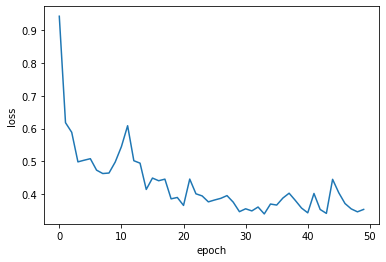

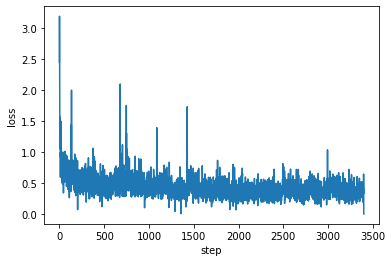

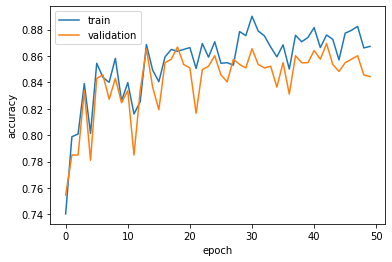

In [ ]:
train_dict = pkl.load(open('/content/dnnbrain/data/models/train_dict.pkl', 'rb'))
plot_graphs(train_dict)

In [ ]:
import itertools

dnn = AlexNet()
n_in_feat = dnn.model.classifier[6].in_features
dnn.model.classifier[6] = torch.nn.Linear(n_in_feat, 11)
lr = 0.00001
n_epoch = 20
conv5_params = dnn.layer2module('conv5').parameters()
fc3_params = dnn.model.classifier[6].parameters()
optimizer = torch.optim.Adam(itertools.chain(conv5_params, fc3_params), lr)
train_dict = dnn.train(X_train, n_epoch, 'classification', target=y_train, data_train=True, data_validation=X_val, target_validation=y_val)
pkl.dump(train_dict, open('/content/dnnbrain/data/models/train_dict_1.pkl', 'wb'))
dnn.save('/content/dnnbrain/data/models/alexnet_tl_finetune_2.pth')

Epoch-1/20
----------
Loss: 0.8760391038464678
Score_on_train: 0.7950628784350257
Score_on_test: 0.7796833773087071
This epoch costs 0m 41s

Epoch-2/20
----------
Loss: 0.7377362871186007
Score_on_train: 0.7349790405216581
Score_on_test: 0.712401055408971
This epoch costs 0m 41s

Epoch-3/20
----------
Loss: 0.5826808653240932
Score_on_train: 0.8514205868653936
Score_on_test: 0.8245382585751979
This epoch costs 0m 42s

Epoch-4/20
----------
Loss: 0.5316958487672366
Score_on_train: 0.8285980437820214
Score_on_test: 0.8324538258575198
This epoch costs 0m 40s

Epoch-5/20
----------
Loss: 0.5111328667965832
Score_on_train: 0.8390777829529577
Score_on_test: 0.8311345646437994
This epoch costs 0m 42s

Epoch-6/20
----------
Loss: 0.5235422540666005
Score_on_train: 0.8362831858407079
Score_on_test: 0.8430079155672823
This epoch costs 0m 41s

Epoch-7/20
----------
Loss: 0.48271446478300223
Score_on_train: 0.8346530041918957
Score_on_test: 0.8350923482849604
This epoch costs 0m 40s

Epoch-8/20
--

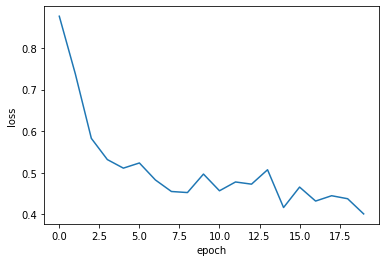

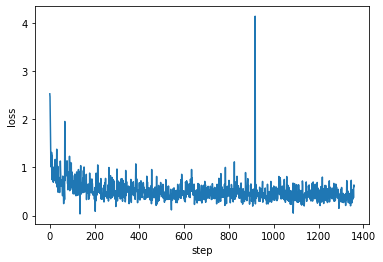

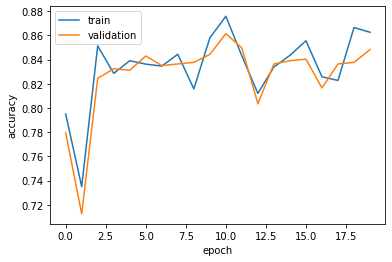

In [ ]:
train_dict = pkl.load(open('/content/dnnbrain/data/models/train_dict_1.pkl', 'rb'))
plot_graphs(train_dict)

In [ ]:
#feature extractor Code
dnn = AlexNet()
for param in dnn.model.parameters():
    param.requires_grad = False
n_in_feat = dnn.model.classifier[6].in_features
dnn.model.classifier[6] = torch.nn.Linear(n_in_feat, 11)
lr = 0.00001
n_epoch = 20
optimizer = torch.optim.Adam(dnn.model.classifier[6].parameters(), lr)
train_dict = dnn.train(X_train, n_epoch, 'classification', target=y_train, data_train=True, data_validation=X_val, target_validation=y_val)
pkl.dump(train_dict, open('/content/dnnbrain/data/models/train_dict_2.pkl', 'wb'))
dnn.save('/content/dnnbrain/data/models/alexnet_tl_fixed_feature_extractor_1.pth')

Epoch-1/20
----------
Loss: 0.7242492772586744
Score_on_train: 0.843735444806707
Score_on_test: 0.8614775725593667
This epoch costs 0m 39s

Epoch-2/20
----------
Loss: 0.45873190670108926
Score_on_train: 0.8612016767582673
Score_on_test: 0.8601583113456465
This epoch costs 0m 39s

Epoch-3/20
----------
Loss: 0.44051319729965344
Score_on_train: 0.8665579878900792
Score_on_test: 0.866754617414248
This epoch costs 0m 38s

Epoch-4/20
----------
Loss: 0.4305064912363158
Score_on_train: 0.8691197019096414
Score_on_test: 0.8614775725593667
This epoch costs 0m 39s

Epoch-5/20
----------
Loss: 0.4253448327030756
Score_on_train: 0.8642291569632045
Score_on_test: 0.8601583113456465
This epoch costs 0m 38s

Epoch-6/20
----------
Loss: 0.4292329858223338
Score_on_train: 0.8607359105728924
Score_on_test: 0.862796833773087
This epoch costs 0m 40s

Epoch-7/20
----------
Loss: 0.419044741181701
Score_on_train: 0.8754075454122031
Score_on_test: 0.8654353562005277
This epoch costs 0m 39s

Epoch-8/20
----

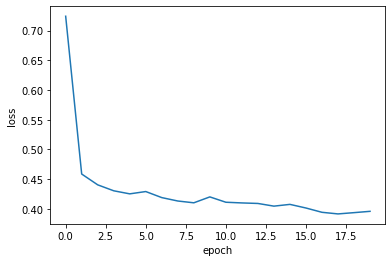

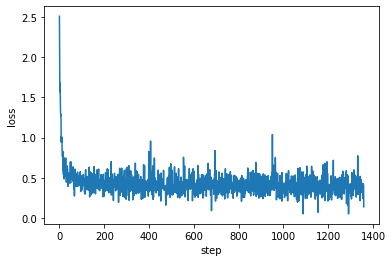

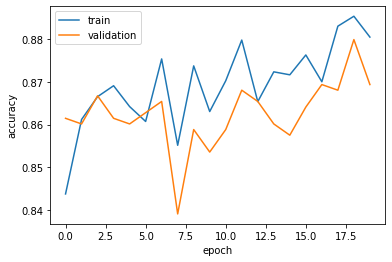

In [ ]:
train_dict = pkl.load(open('/content/dnnbrain/data/models/train_dict_2.pkl', 'rb'))
plot_graphs(train_dict)

In [ ]:
import numpy as np
import pickle as pkl

from torch import nn
from PIL import Image
from os.path import join as pjoin
from torchvision import transforms
from torchvision import models as tv_models
from dnnbrain.dnn.models import DNN
from dnnbrain.dnn.core import Stimulus

In [ ]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv = nn.Conv2d(3, 8, kernel_size=3, stride=2)
        self.relu1 = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2)
        self.fc1 = nn.Linear(24200, 4096)
        self.relu2 = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(4096, 11)

    def forward(self, x):
        x = self.conv(x)
        self.relu1(x)
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        self.relu2(x)
        x = self.fc2(x)
        return x

In [ ]:
img_size = (224, 224)
mean = X.mean(axis=(0, 2, 3)) / 255
std = X.std(axis=(0, 2, 3)) / 255
normalize = transforms.Normalize(mean=mean, std=std)

In [ ]:
class MyDNN(DNN):

    def __init__(self):
        super(MyDNN, self).__init__()
        self.model = Model()
        self.img_size = img_size
        self.train_transform = transforms.Compose([
            transforms.RandomResizedCrop(img_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize
        ])
        self.test_transform = transforms.Compose([
            transforms.Resize(img_size),
            transforms.ToTensor(),
            normalize
        ])


dnn = MyDNN()

In [ ]:
# change model.py
train_dict = dnn.train(X_train, 10, 'classification', target=y_train, data_train=True, data_validation=X_val, target_validation=y_val)

# save information of training process
pkl.dump(train_dict, open('/content/dnnbrain/data/models/train_dict_scratch.pkl', 'wb'))

# save parameters of the DNN
dnn.save('/content/dnnbrain/data/models/my_model.pth')

Epoch-1/10
----------


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Loss: 2.3383295400841155
Score_on_train: 0.7370749883558454
Score_on_test: 0.7493403693931399
This epoch costs 0m 26s

Epoch-2/10
----------
Loss: 0.6639003844443288
Score_on_train: 0.8295295761527713
Score_on_test: 0.8218997361477572
This epoch costs 0m 30s

Epoch-3/10
----------
Loss: 0.48176162764881175
Score_on_train: 0.8311597578015836
Score_on_test: 0.8179419525065963
This epoch costs 0m 30s

Epoch-4/10
----------
Loss: 0.4311492989125172
Score_on_train: 0.8248719142990218
Score_on_test: 0.820580474934037
This epoch costs 0m 29s

Epoch-5/10
----------
Loss: 0.4502537214011995
Score_on_train: 0.7955286446204005
Score_on_test: 0.8047493403693932
This epoch costs 0m 30s

Epoch-6/10
----------
Loss: 0.4231298434273498
Score_on_train: 0.8183511877037727
Score_on_test: 0.7915567282321899
This epoch costs 0m 31s

Epoch-7/10
----------
Loss: 0.3965182024820716
Score_on_train: 0.8563111318118305
Score_on_test: 0.8311345646437994
This epoch costs 0m 31s

Epoch-8/10
----------
Loss: 0.41582

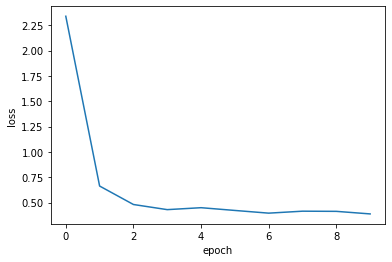

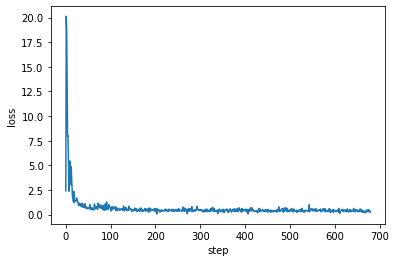

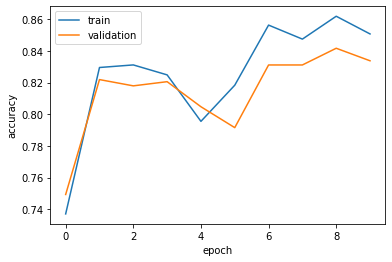

In [ ]:
train_dict = pkl.load(open('/content/dnnbrain/data/models/train_dict_scratch.pkl', 'rb'))
plot_graphs(train_dict)